# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("../../")

In [2]:
os.environ.get("CONDA_PREFIX")

'/epyc/opt/anaconda'

In [3]:
os.nice(1)

1

In [4]:
import thor

In [5]:
DATABASE = "/epyc/projects/thor/data/msst_survey.db"
con = sql.connect(DATABASE)

# Load Data

In [6]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59754""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59754""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2315689
2313850


In [7]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [8]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [9]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

(140, 200)

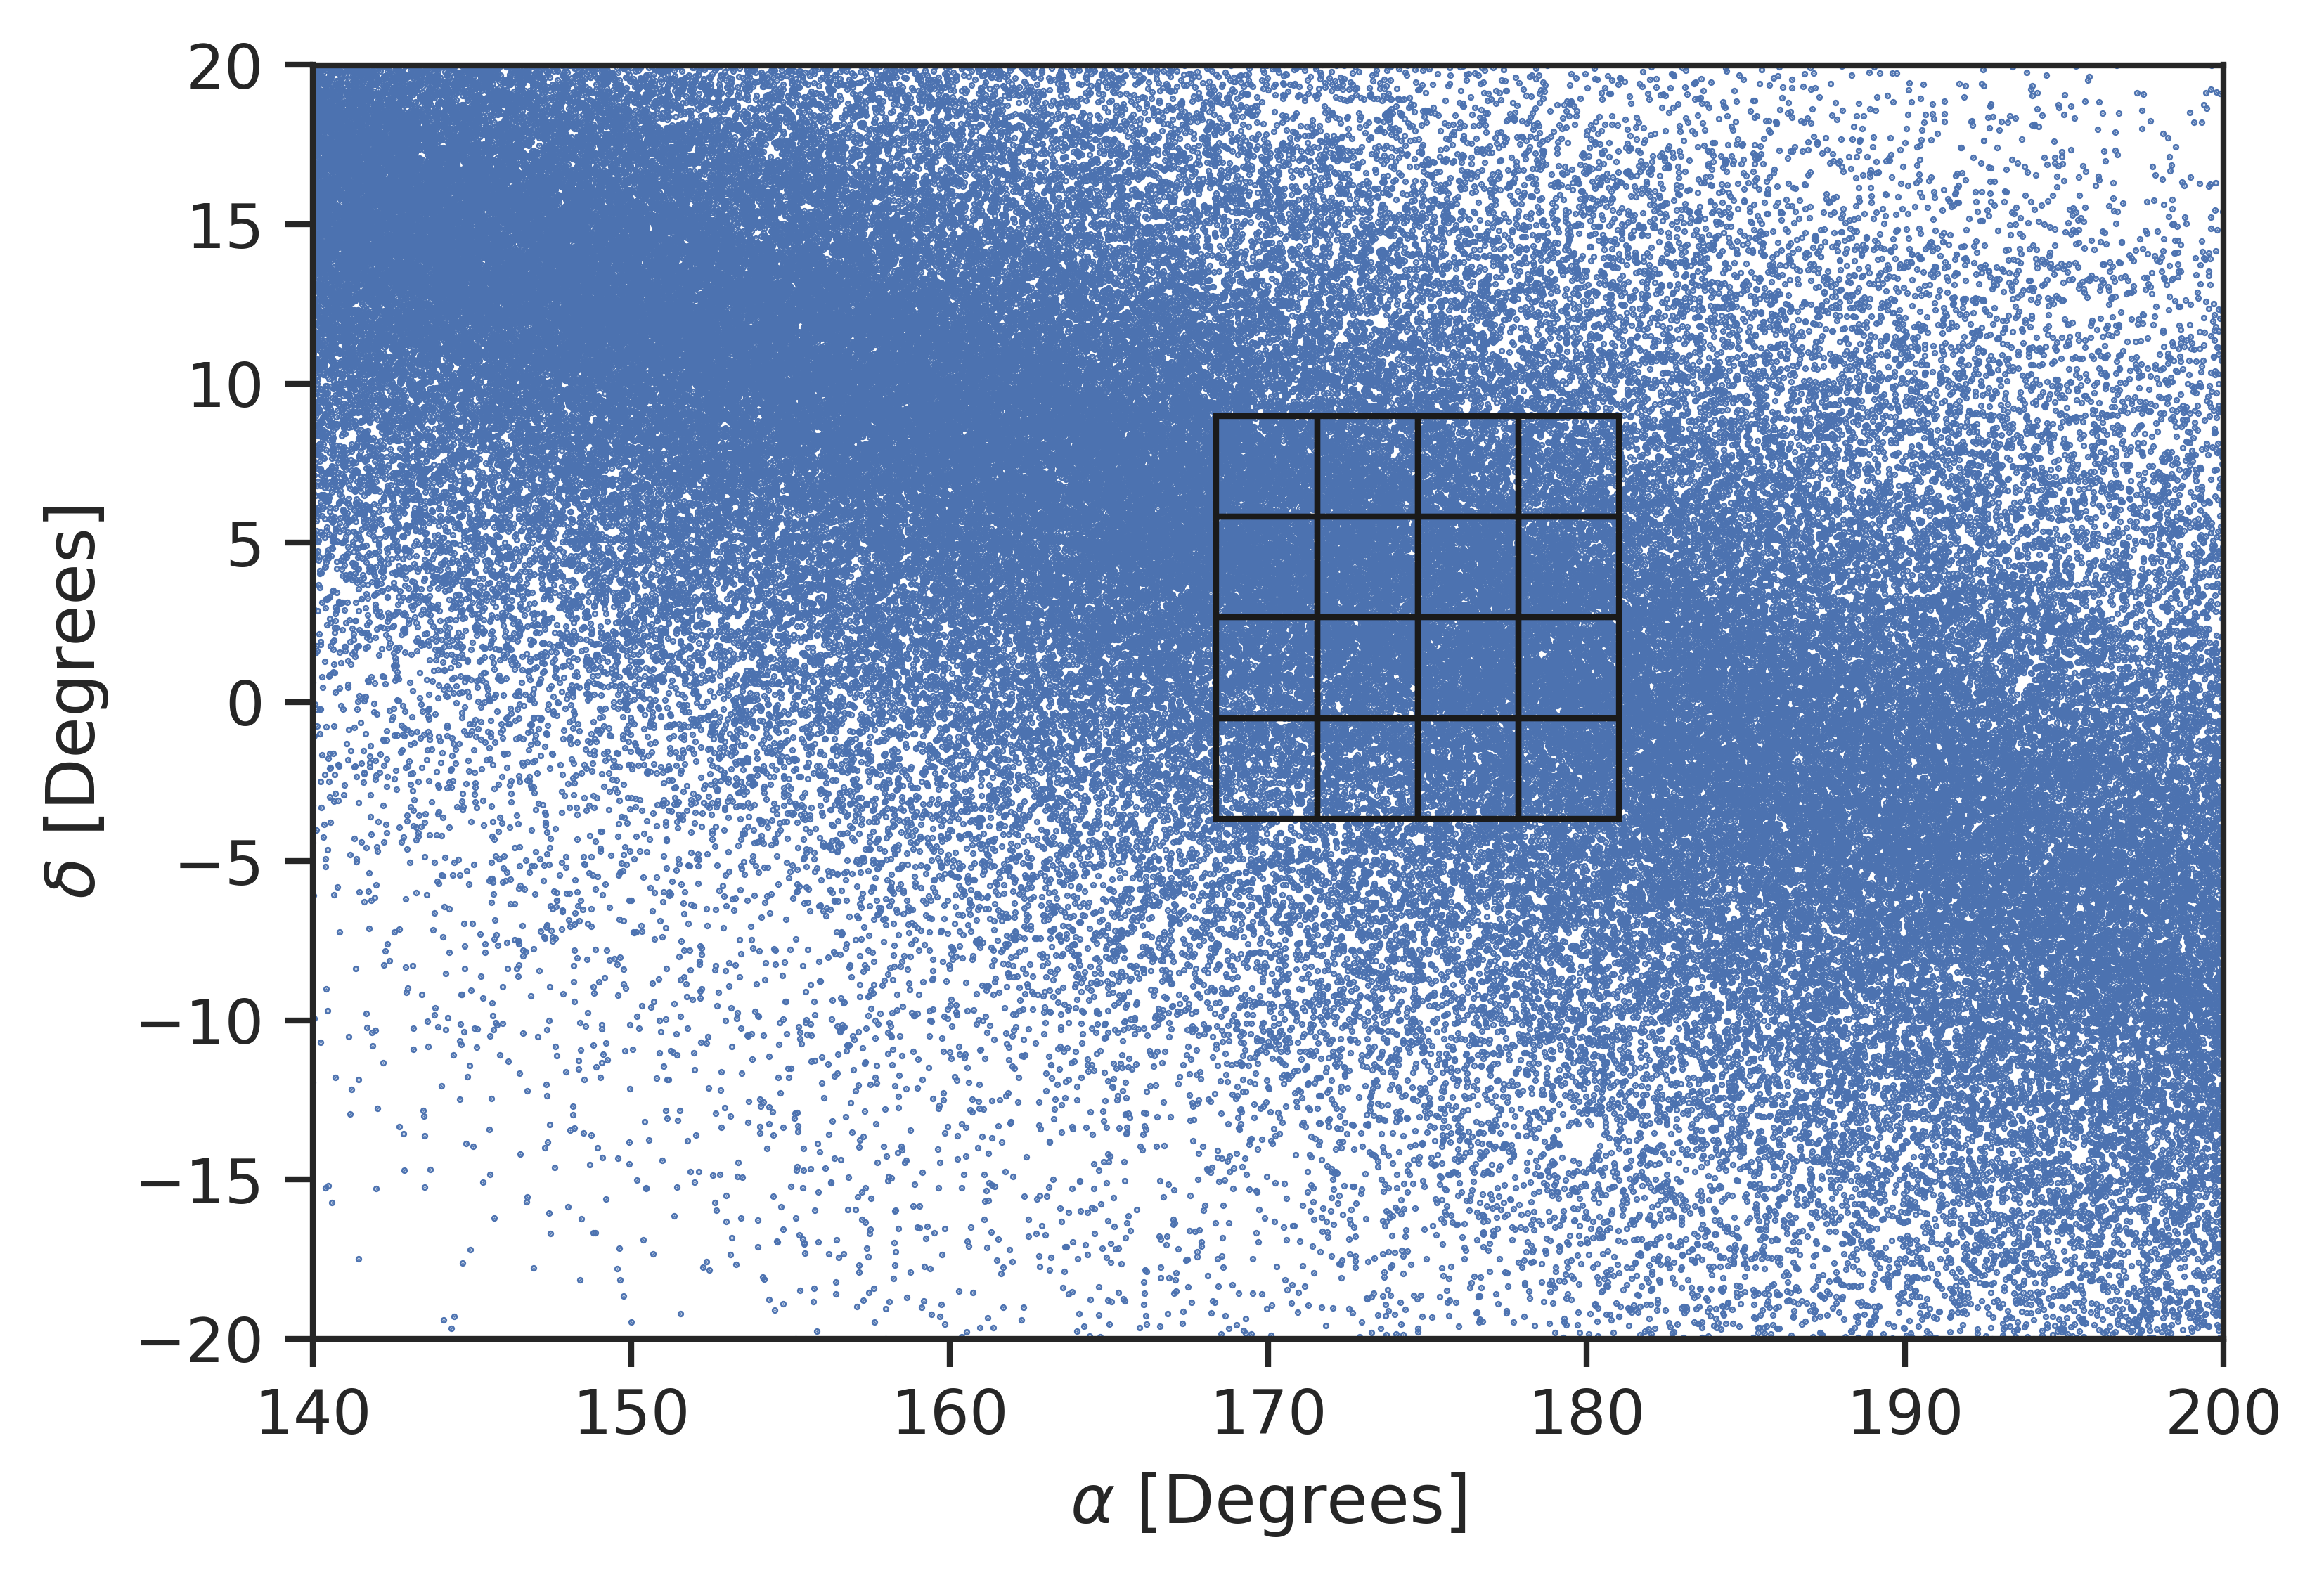

In [10]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel(r"$\alpha$ [Degrees]")
ax.set_ylabel(r"$\delta$ [Degrees]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(140, 200)

## Make Reduced Survey

In [11]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]
#observations.to_csv("../analysis/msst_4x4/observations.txt", sep=" ", index=False)

In [12]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)
#orbits.to_csv("../analysis/msst_4x4/orbits.txt", sep=" ", index=False)

(5.642774417833482, 9.132279844018699)

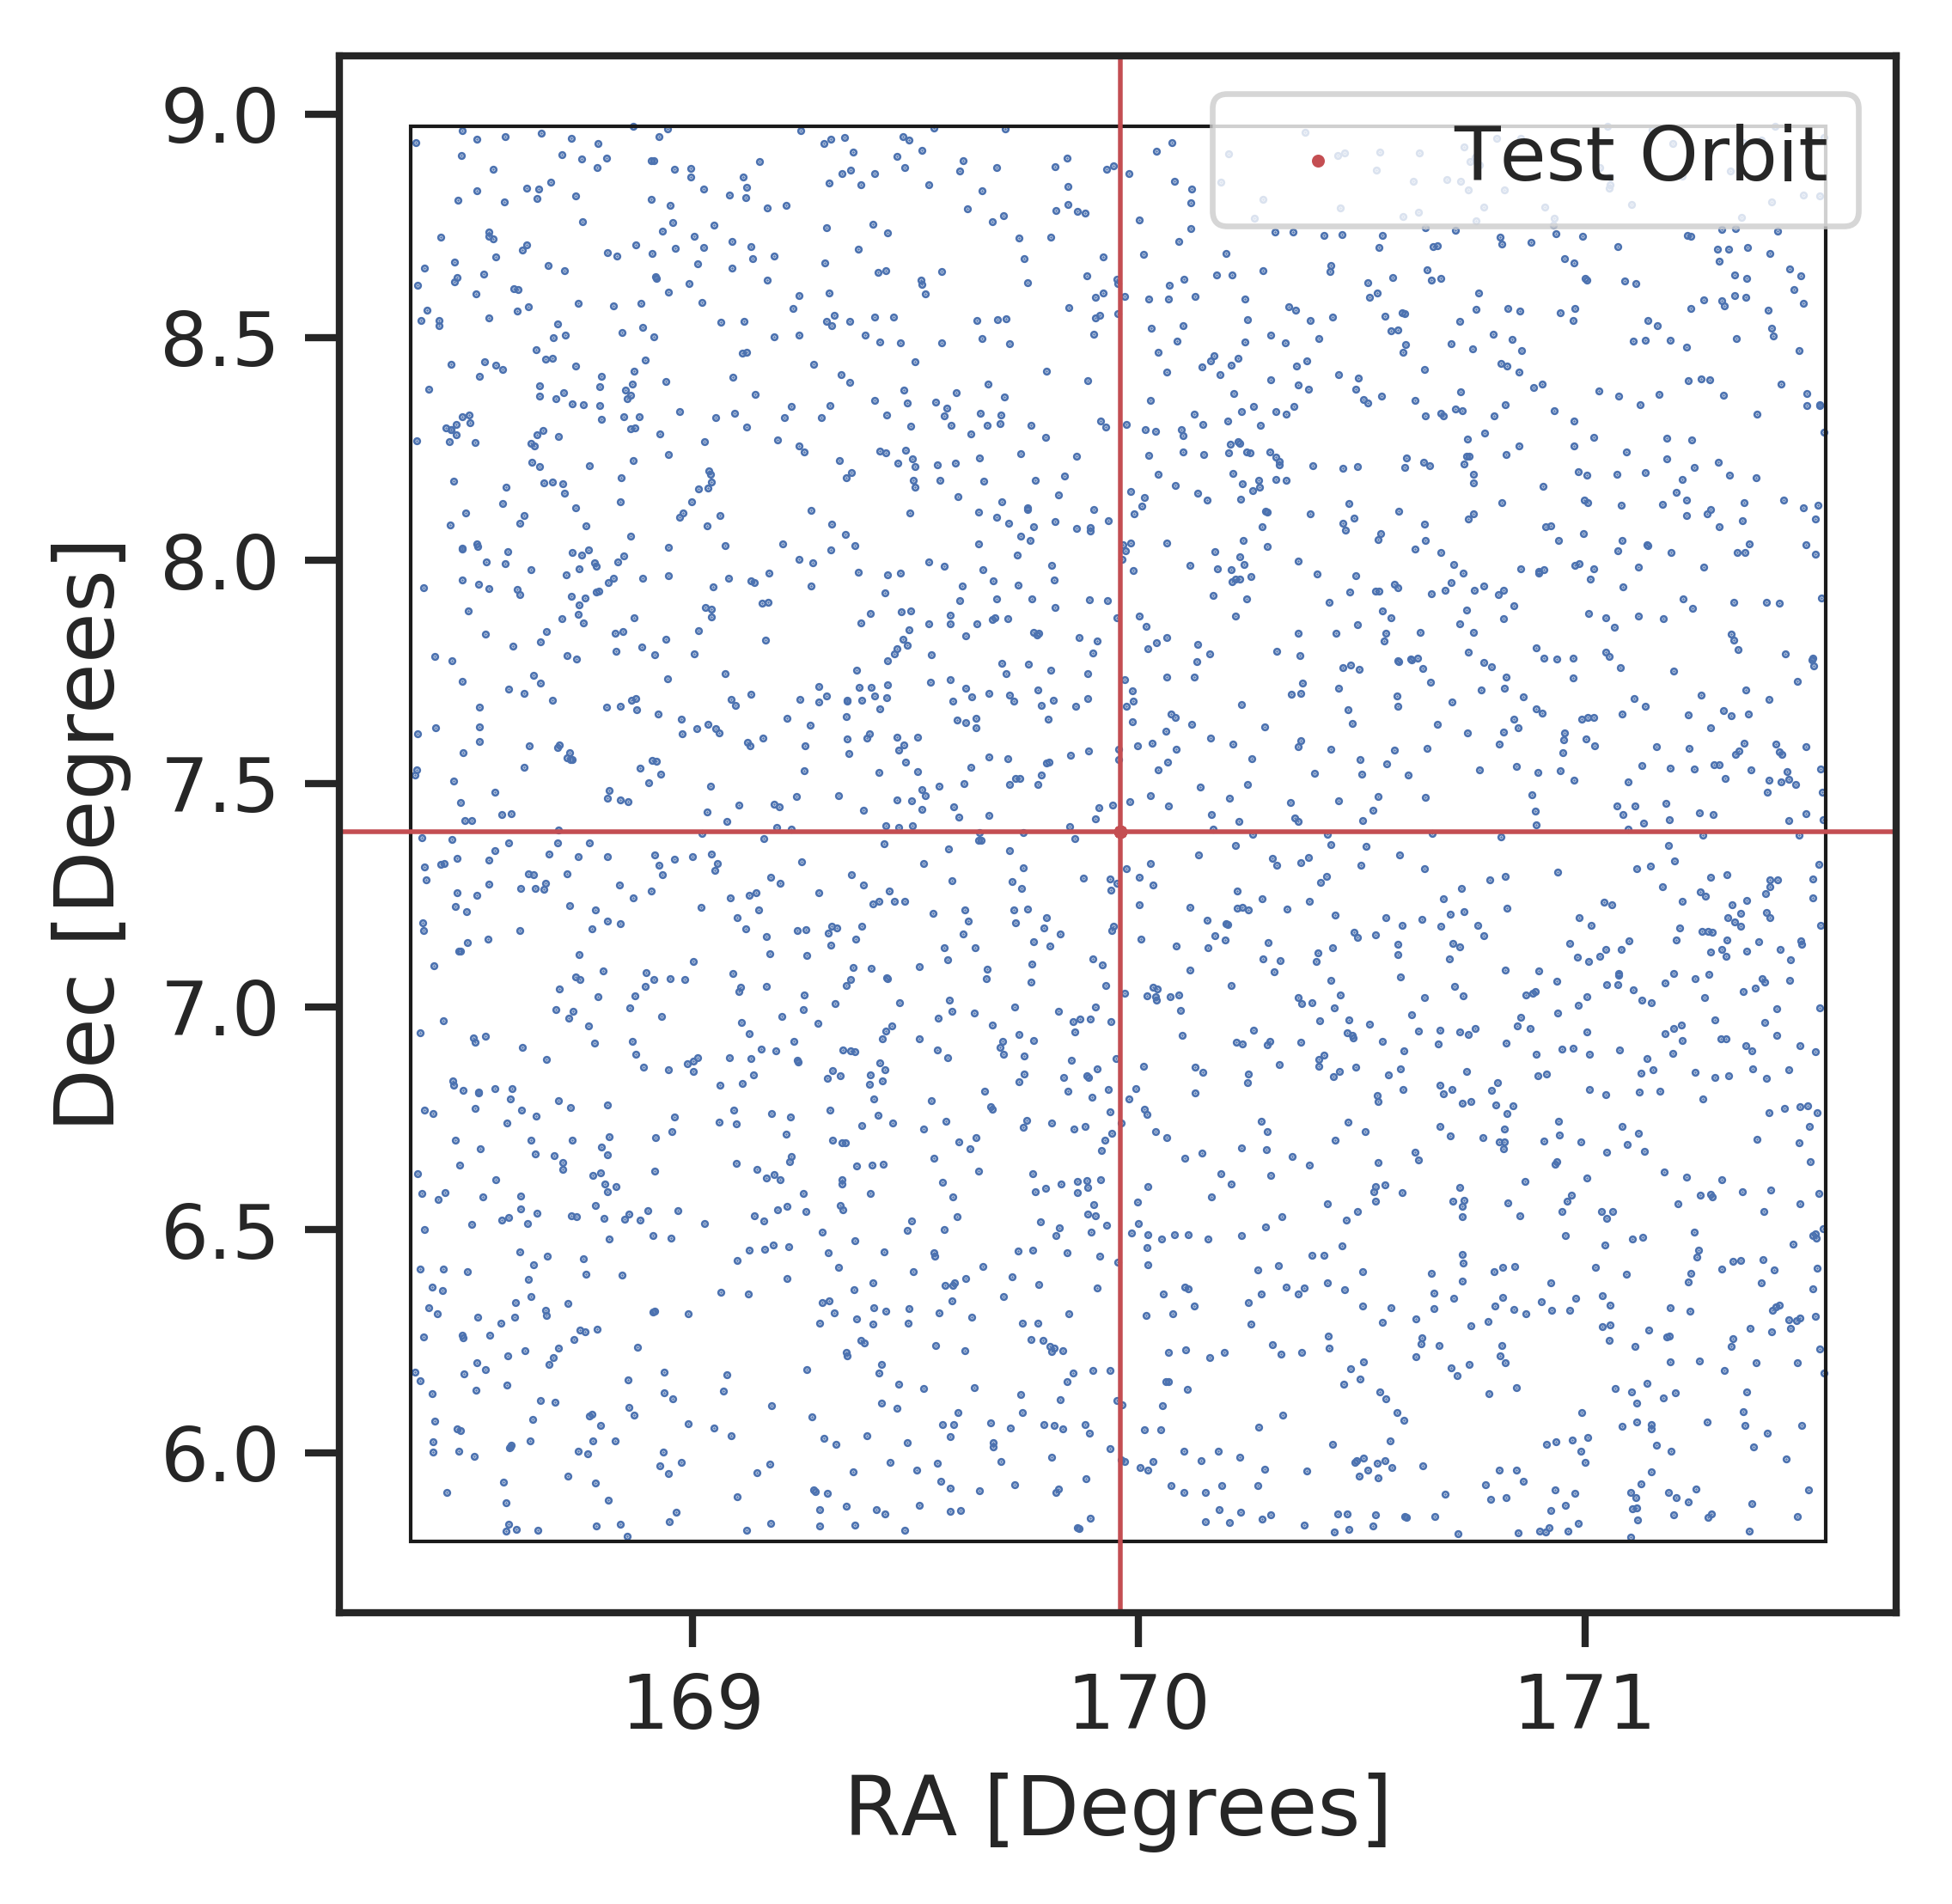

In [13]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2- 0.01, yy-yField/2 -0.01), xField+0.01, yField+0.01, fill=False, lw=0.5, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.scatter(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, s=1, c="r", 
           label="Test Orbit")
ax.legend()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, *xlim, lw=0.5, color="r")
ax.vlines(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, *ylim, lw=0.5, color="r")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [14]:
allObjects_survey, summary_survey = thor.analyzeObservations(observations)

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 139120
Unknown object observations: 0
False positive observations: 112078
Percent known object observations (%): 55.383
Percent unknown object observations (%): 0.000
Percent false positive observations (%): 44.617
Unique known objects: 24481
Unique known objects with at least 5 detections: 18332

Total time in seconds: 0.25952577590942383
-------------------------



In [15]:
average_orbits_hun1 = thor.findAverageOrbits(observations[observations["night"] == observations["night"].min()],
                                            orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] <= 0.1)],
                                            elementType="keplerian",
                                            dValues=[1.7, 2.06])
average_orbits_hun2 = thor.findAverageOrbits(observations[observations["night"] == observations["night"].min()],
                                             orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] > 0.1) & (orbits["e"] <= 0.2)],
                                             elementType="keplerian",
                                             dValues=[1.7, 2.06])
average_orbits_hun3 = thor.findAverageOrbits(observations[observations["night"] == observations["night"].min()],
                                             orbits[(orbits["a_au"] < 2.06) & (orbits["a_au"] >= 1.7) & (orbits["e"] > 0.2) & (orbits["e"] <= 0.4) ],
                                             elementType="keplerian",
                                             dValues=[1.7, 2.06])

average_orbits = thor.findAverageOrbits(observations[observations["night"] == observations["night"].min()],
                                        orbits,
                                        elementType="keplerian",
                                        dValues=[2.06, 2.5, 2.82, 2.95, 3.27, 5.0])
average_orbits = pd.concat([average_orbits_hun1, average_orbits_hun2, average_orbits_hun3, average_orbits])
average_orbits.sort_values(by="a_au", inplace=True)
average_orbits["orbit_id"] = np.arange(1, len(average_orbits) + 1)
average_orbits.reset_index(inplace=True, drop=True)


THOR: findAverageObject
-------------------------
Finding average orbit in 1 distance bins...
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 1 distance bins...
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 1 distance bins...
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 5 distance bins...
Done.
-------------------------



In [18]:
average_orbits

orbit_id      r_au  HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  \
0         1  2.015926                0.005203               -0.009630   
1         2  2.466386                0.001472               -0.008939   
2         3  2.126557                0.003461               -0.009784   
3         4  2.224564                0.002745               -0.011507   
4         5  3.047675                0.001167               -0.009082   
5         6  3.140849                0.001035               -0.009255   
6         7  3.498810                0.001374               -0.008503   
7         8  4.820295                0.000900               -0.006856   

   HEclObj_dZ/dt_au_p_day       exp_mjd      RA_deg   Dec_deg      a_au  \
0               -0.004288  59740.247222  175.508373  1.543560  1.904373   
1                0.001756  59740.246528  175.272855  2.901712  1.911554   
2                0.003993  59740.238194  173.870026  0.105095  1.913353   
3                0.000024  59740.237500  174.377710 -2.535696  2.346804   
4                0.000384  59740.220139  170.619629 -0.815534  2.685105   
5                0.000171  59740.218056  168.738396  8.117743  2.910515   
6                0.000890  59740.246528  177.481435  4.897453  3.142568   
7               -0.000111  59740.239583  174.304855  7.069568  3.947871   

      i_deg         e designation  
0  21.43531  0.075697       n0358  
1  11.02403  0.328983     K10T54J  
2  21.24912  0.118536     K17H05D  
3   3.89117  0.171452       79151  
4   4.93152  0.149272       T8186  
5   3.10391  0.080989       18043  
6   6.56006  0.129820     K14WS3Y  
7   4.14559  0.228410     K10O54W

In [ ]:
allObjects_survey, summary_survey, summary_orbits = thor.runTHOR(observations, 
                                                                 average_orbits, 
                                                                 knownOrbits=orbits,
                                                                 runDir="../../analysis/msst_4x4/run_14/", 
                                                                 cellArea=500,
                                                                 cellShape="circle",
                                                                 threads=40,
                                                                 vxBins=300,
                                                                 vyBins=300,
                                                                 vxRange=[-0.1, 0.1],
                                                                 vyRange=[-0.1, 0.1],
                                                                 eps=0.005,
                                                                 minSamples=5)